In [1]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import holidays

# For SARIMAX
from tqdm import tqdm
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

# For FBProphet
from fbprophet import Prophet

# For LightGBM
import lightgbm as lgb
from sklearn.model_selection import train_test_split
import optuna

In [2]:
def return_series(csv_path):
    """
    
    """
    
    def parse(x):
        return datetime.datetime.strptime(x, '%m/%d/%Y %H')
    
    df = pd.read_csv(csv_path, parse_dates=[['Date','Hour']], date_parser=parse)
    df = df.loc[~df.duplicated()]
    
    return df

In [3]:
df = return_series('mta.csv')

In [4]:
conditions = [
df['Plaza ID'].eq(21) | df['Plaza ID'].eq(1),
df['Plaza ID'].eq(22) | df['Plaza ID'].eq(2),
df['Plaza ID'].eq(23) | df['Plaza ID'].eq(3),
df['Plaza ID'].eq(24) | df['Plaza ID'].eq(4),
df['Plaza ID'].eq(25) | df['Plaza ID'].eq(5),
df['Plaza ID'].eq(26) | df['Plaza ID'].eq(6),
df['Plaza ID'].eq(27) | df['Plaza ID'].eq(7),
df['Plaza ID'].eq(28) | df['Plaza ID'].eq(8),
df['Plaza ID'].eq(29) | df['Plaza ID'].eq(9),
df['Plaza ID'].eq(30) | df['Plaza ID'].eq(11)
]
choices = [
    'Triboro',
    'Triboro',
    'Whitestone',
    'Henry Hudson',
    'Marine Parkway',
    'Cross Bay',
    'Queens Midtown',
    'Brooklyn Battery',
    'Throgs Neck',
    'Verrazano'
]
df['plaza_id'] = np.select(conditions, choices, 0)

In [5]:
df.rename(columns={'# Vehicles - E-ZPass': 'ezpass', '# Vehicles - VToll': 'cash'}, inplace=True)

In [6]:
df

,Date_Hour,Plaza ID,Direction,ezpass,cash,plaza_id
0,2020-10-24 00:00:00,21,I,1838,578,Triboro
1,2020-10-24 01:00:00,21,I,1084,372,Triboro
2,2020-10-24 02:00:00,21,I,805,260,Triboro
3,2020-10-24 03:00:00,21,I,766,211,Triboro
4,2020-10-24 04:00:00,21,I,1049,268,Triboro
...,...,...,...,...,...,...
1666242,2010-01-01 19:00:00,11,I,2675,1152,Verrazano
1666243,2010-01-01 20:00:00,11,I,2580,1086,Verrazano
1666244,2010-01-01 21:00:00,11,I,2302,987,Verrazano
1666245,2010-01-01 22:00:00,11,I,2170,910,Verrazano


In [7]:
df.drop(columns=['Plaza ID', 'Direction'], inplace=True)
df

,Date_Hour,ezpass,cash,plaza_id
0,2020-10-24 00:00:00,1838,578,Triboro
1,2020-10-24 01:00:00,1084,372,Triboro
2,2020-10-24 02:00:00,805,260,Triboro
3,2020-10-24 03:00:00,766,211,Triboro
4,2020-10-24 04:00:00,1049,268,Triboro
...,...,...,...,...
1666242,2010-01-01 19:00:00,2675,1152,Verrazano
1666243,2010-01-01 20:00:00,2580,1086,Verrazano
1666244,2010-01-01 21:00:00,2302,987,Verrazano
1666245,2010-01-01 22:00:00,2170,910,Verrazano


In [8]:
df.columns = ['datetime', 'ezpass', 'cash', 'plaza_id']

In [9]:
_df = df.melt(id_vars=['datetime','plaza_id'], value_vars=['ezpass', 'cash'])
_df.set_index('datetime', inplace=True)
_df = _df.groupby(['plaza_id', 'variable'])['value'].resample('1D').sum()

In [10]:
_df

plaza_id          variable  datetime  
Brooklyn Battery  cash      2010-01-01      4902
                            2010-01-02      5347
                            2010-01-03      4957
                            2010-01-04      5759
                            2010-01-05      6096
                                           ...  
Whitestone        ezpass    2020-10-20     96450
                            2020-10-21     99916
                            2020-10-22    104943
                            2020-10-23    109848
                            2020-10-24    103156
Name: value, Length: 71100, dtype: int64

In [11]:
a = _df.unstack().T

In [12]:
a.columns

MultiIndex([('Brooklyn Battery',   'cash'),
            ('Brooklyn Battery', 'ezpass'),
            (       'Cross Bay',   'cash'),
            (       'Cross Bay', 'ezpass'),
            (    'Henry Hudson',   'cash'),
            (    'Henry Hudson', 'ezpass'),
            (  'Marine Parkway',   'cash'),
            (  'Marine Parkway', 'ezpass'),
            (  'Queens Midtown',   'cash'),
            (  'Queens Midtown', 'ezpass'),
            (     'Throgs Neck',   'cash'),
            (     'Throgs Neck', 'ezpass'),
            (         'Triboro',   'cash'),
            (         'Triboro', 'ezpass'),
            (       'Verrazano',   'cash'),
            (       'Verrazano', 'ezpass'),
            (      'Whitestone',   'cash'),
            (      'Whitestone', 'ezpass')],
           names=['plaza_id', 'variable'])

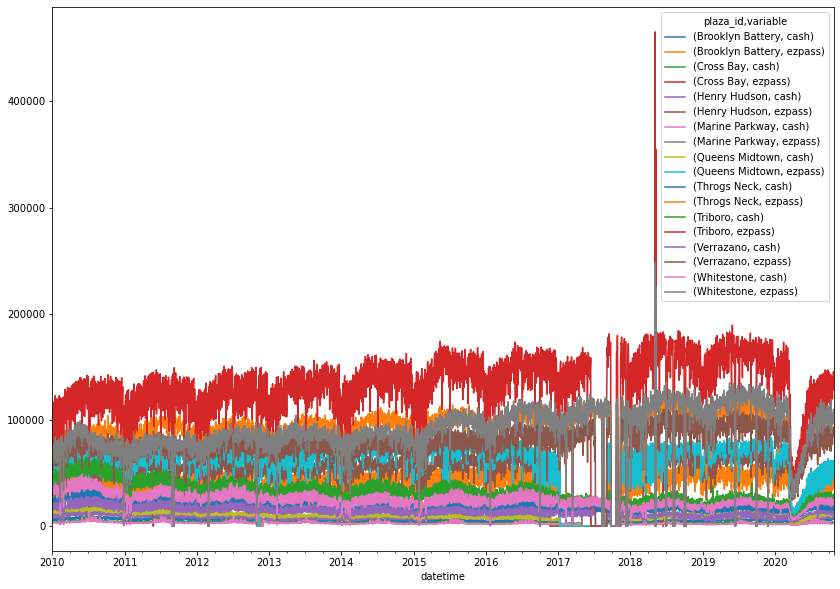

In [13]:
fig, ax = plt.subplots(figsize=(14,10))
a.plot(ax = ax)

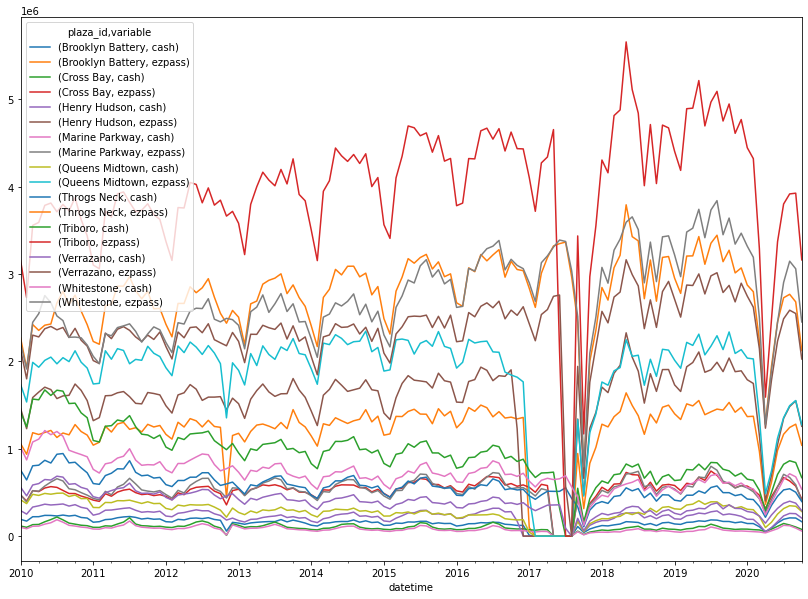

In [14]:
a.resample('1M').sum().plot(figsize=(14,10))

In [75]:
_a = a[:'2020-02'].copy(deep=True)

In [76]:
_a[('Brooklyn Battery', 'cash')].describe()

count     3712.000000
mean      5018.543373
std       1977.037927
min          0.000000
25%       4434.250000
50%       5181.000000
75%       6074.250000
max      13953.000000
Name: (Brooklyn Battery, cash), dtype: float64

In [77]:
for i in _a.columns:
    print(i, _a[i].mean() - _a[i].std() * 2, _a[i].mean() + _a[i].std() * 2)

('Brooklyn Battery', 'cash') 1064.4675187552316 8972.619226934425
('Brooklyn Battery', 'ezpass') 9431.270599655913 69255.04513310271
('Cross Bay', 'cash') 293.7279581169719 6384.422903951994
('Cross Bay', 'ezpass') 6587.71548581645 27905.75326418355
('Henry Hudson', 'cash') 1334.0785876519158 13710.892317520498
('Henry Hudson', 'ezpass') 12834.290998501187 88624.12333339537
('Marine Parkway', 'cash') 80.91117516288568 5163.887855009529
('Marine Parkway', 'ezpass') 6543.046640777544 28691.764242843143
('Queens Midtown', 'cash') 1681.8596376783744 17238.92861663197
('Queens Midtown', 'ezpass') 18269.325562113758 106062.75471805866
('Throgs Neck', 'cash') 7549.813624375727 30516.845858382898
('Throgs Neck', 'ezpass') 54114.71124818096 131961.71816992247
('Triboro', 'cash') 9362.213367438908 53436.96174031972
('Triboro', 'ezpass') 59690.65270054083 203353.64794601087
('Verrazano', 'cash') 3794.890055666572 22388.070612436877
('Verrazano', 'ezpass') 40225.15998202289 116069.48603090816
('Wh

In [78]:
for i in _a.columns:
    conditions = [
        _a[i] < _a[i].mean() - _a[i].std() * 2,
        _a[i] > _a[i].mean() + _a[i].std() * 2
    ]
    choices = [
        np.nan,
        np.nan
    ]
    _a[i] = np.select(conditions, choices, _a[i])

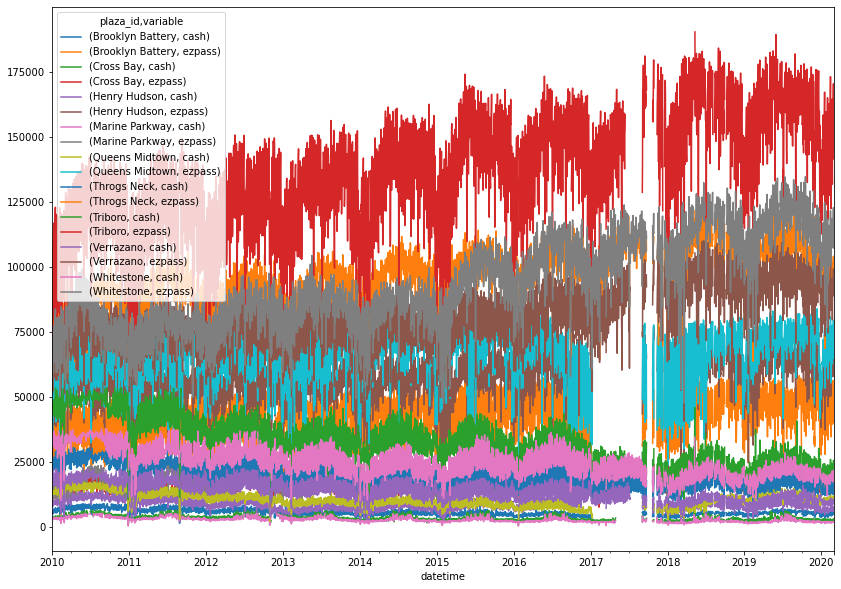

In [79]:
_a.plot(figsize=(14,10))

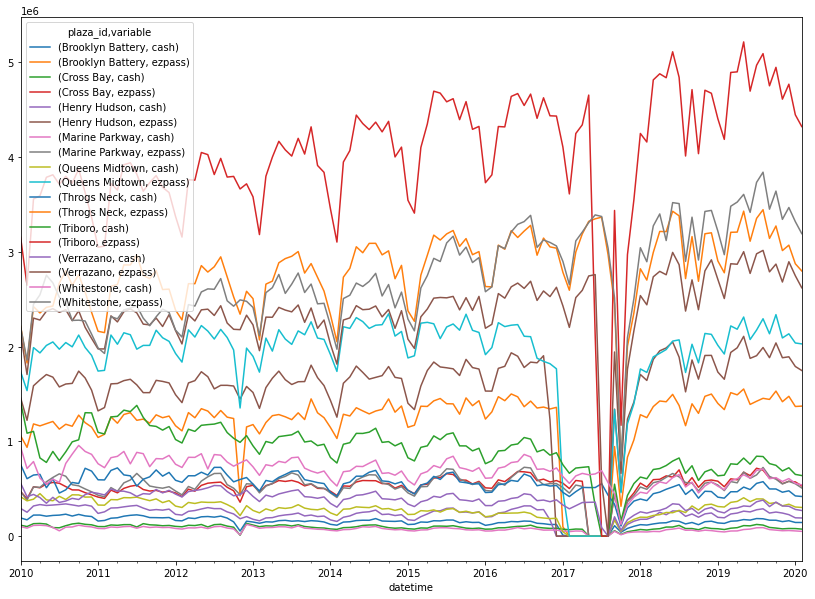

In [80]:
_a.resample('1M').sum().plot(figsize=(14,10))

In [81]:
_a.isna().sum()

plaza_id          variable
Brooklyn Battery  cash        363
                  ezpass      338
Cross Bay         cash        368
                  ezpass      213
Henry Hudson      cash        379
                  ezpass      368
Marine Parkway    cash        361
                  ezpass      227
Queens Midtown    cash        355
                  ezpass      324
Throgs Neck       cash        196
                  ezpass      117
Triboro           cash        259
                  ezpass      172
Verrazano         cash        251
                  ezpass      154
Whitestone        cash        193
                  ezpass      105
dtype: int64

In [82]:
_a.isna().sum().sum()

4743

In [98]:
_a.head(50)

plaza_id   Brooklyn Battery          Cross Bay          Henry Hudson           \
variable               cash   ezpass      cash   ezpass         cash   ezpass   
datetime                                                                        
2010-01-01           4902.0  17043.0    3577.0   9760.0       7491.0  27175.0   
2010-01-02           5347.0  20799.0    3508.0  11673.0       9396.0  37110.0   
2010-01-03           4957.0  21605.0    3030.0   9983.0       7959.0  34720.0   
2010-01-04           5759.0  35557.0    3494.0  16032.0       8653.0  45846.0   
2010-01-05           6096.0  38810.0    3647.0  16821.0       8818.0  49009.0   
2010-01-06           6673.0  41777.0    3813.0  17274.0       9251.0  52007.0   
2010-01-07           6807.0  42533.0    3856.0  17623.0       9720.0  54067.0   
2010-01-08           6437.0  36528.0    3966.0  17031.0       9831.0  48588.0   
2010-01-09           6158.0  25932.0    3799.0  13155.0       9952.0  41438.0   
2010-01-10           5462.0  26637.0    3333.0  11104.0       8533.0  39300.0   
2010-01-11           5811.0  38076.0    3541.0  16572.0       8598.0  49379.0   
2010-01-12           6125.0  41097.0    3594.0  17265.0       8780.0  52757.0   
2010-01-13           6264.0  41379.0    3761.0  17352.0       9204.0  52965.0   
2010-01-14           6421.0  42048.0    3642.0  17683.0       9652.0  55762.0   
2010-01-15           7288.0  39878.0    4194.0  17642.0      11339.0  56198.0   
2010-01-16           6737.0  27368.0    4109.0  13943.0      11033.0  43950.0   
2010-01-17           5481.0  24933.0    3297.0  10538.0       8739.0  38510.0   
2010-01-18           5232.0  30097.0    3568.0  13574.0       8544.0  43188.0   
2010-01-19           5893.0  39609.0    3552.0  16693.0       8974.0  51528.0   
2010-01-20           6413.0  40546.0    3670.0  17314.0       9360.0  53155.0   
2010-01-21           6684.0  41297.0    3838.0  17707.0       9922.0  54785.0   
2010-01-22           7008.0  39175.0    4061.0  17927.0      11233.0  54758.0   
2010-01-23           7052.0  28593.0    4134.0  14446.0      11576.0  46135.0   
2010-01-24           5405.0  24617.0    3469.0  10929.0       9268.0  40229.0   
2010-01-25           6348.0  38218.0    3379.0  15394.0       8061.0  44897.0   
2010-01-26           6227.0  39819.0    3702.0  17268.0       9067.0  52037.0   
2010-01-27           6147.0  40059.0    3811.0  17760.0       9516.0  54438.0   
2010-01-28           6418.0  40512.0    3698.0  17466.0       8624.0  48508.0   
2010-01-29           7509.0  40537.0    4185.0  17843.0      10895.0  55367.0   
2010-01-30           6596.0  26985.0    4056.0  13686.0      10193.0  40427.0   
2010-01-31           6068.0  27040.0    3567.0  11586.0       9520.0  42509.0   
2010-02-01           6109.0  39076.0    3679.0  16848.0       9183.0  50032.0   
2010-02-02           5992.0  40773.0    3775.0  17102.0       9213.0  52237.0   
2010-02-03           6112.0  40658.0    3729.0  16854.0       8999.0  50787.0   
2010-02-04           7127.0  43969.0    4032.0  17679.0      10384.0  57514.0   
2010-02-05           6995.0  38832.0    4555.0  18152.0      11019.0  54278.0   
2010-02-06           4264.0  18102.0    3248.0  10593.0       7346.0  31278.0   
2010-02-07           5343.0  24262.0    3686.0  11328.0       7924.0  36836.0   
2010-02-08           6073.0  38525.0    3864.0  16631.0       8955.0  49912.0   
2010-02-09           6966.0  44070.0    3951.0  18082.0       9683.0  54821.0   
2010-02-10           2067.0  13485.0    1590.0      NaN       1983.0      NaN   
2010-02-11           4411.0  29513.0    2837.0  12765.0       7274.0  39400.0   
2010-02-12           7659.0  38854.0    3975.0  17045.0      11959.0  56383.0   
2010-02-13           7351.0  27538.0    4192.0  13296.0      11460.0  43007.0   
2010-02-14           7758.0  30845.0    3626.0  11446.0      10576.0  39421.0   
2010-02-15           5597.0  27139.0    3634.0  12844.0       9005.0  41448.0   
2010-02-16           5612.0  35

In [106]:
_a_to_fill = _a.unstack().reset_index()

In [107]:
_a_to_fill.rename(columns={0: 'value'}, inplace=True)

In [108]:
_a_to_fill

,plaza_id,variable,datetime,value
0,Brooklyn Battery,cash,2010-01-01,4902.0
1,Brooklyn Battery,cash,2010-01-02,5347.0
2,Brooklyn Battery,cash,2010-01-03,4957.0
3,Brooklyn Battery,cash,2010-01-04,5759.0
4,Brooklyn Battery,cash,2010-01-05,6096.0
...,...,...,...,...
66811,Whitestone,ezpass,2020-02-25,111954.0
66812,Whitestone,ezpass,2020-02-26,114578.0
66813,Whitestone,ezpass,2020-02-27,118259.0
66814,Whitestone,ezpass,2020-02-28,122713.0


In [112]:
holidays_2018_2020 = []
for year in range(2010,2022):
    for date in holidays.UnitedStates(years=year).items():
        holidays_2018_2020.append(date[0])

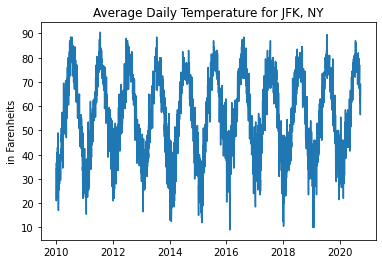

In [114]:
temperature = pd.read_csv('weather.csv', sep ='\t', engine ='python')
temperature['datetime'] = pd.to_datetime(temperature['datetime'])
plt.plot(temperature['datetime'], temperature['temp_average'])
plt.title('Average Daily Temperature for JFK, NY');
plt.ylabel('in Farenheits');

In [116]:
def date_features(_df):
    _df['month'] = _df.index.month
    _df['dayofweek'] = _df.index.dayofweek
    _df['year'] = _df.index.year
    _df['week'] = _df.index.isocalendar().week
    _df['day'] = _df.index.day
    _df['quarter'] = _df.index.quarter
    _df['dayofyear'] = _df.index.dayofyear


#     conditions = [
#         (_df.index >= '2020-03-12') & (_df.index < '2020-03-22'),
#         (_df.index >= '2020-03-22') & (_df.index < '2020-04-16'),
#         (_df.index >= '2020-04-16') & (_df.index < '2020-05-15'),
#         (_df.index >= '2020-05-15') & (_df.index < '2020-06-08'),
#         (_df.index >= '2020-06-08') & (_df.index < '2020-06-22'),
#         (_df.index >= '2020-06-22') & (_df.index < '2020-07-06'),
#         (_df.index >= '2020-07-06') & (_df.index < '2020-07-19'),
#         (_df.index >= '2020-07-19')
#     ]

#     choices = [
#         0,
#         1,
#         2,
#         3,
#         4,
#         5,
#         6,
#         7,
#     ]

#     _df['Phase'] = np.select(conditions, choices, -1)
    
    _df['weekend'] = (_df.index.dayofweek>4).astype(int)
    _df['holiday'] = np.where(_df.index.isin(holidays_2018_2020), 1, 0)
    return _df



In [117]:
_temperature = date_features(temperature.set_index('datetime')[['temp_average']])
_fb_weather = _temperature.reset_index()[['datetime', 'temp_average']]
_fb_weather.columns = ['ds', 'y']
_fb_weather.head()

,ds,y
0,2010-01-01,36.5
1,2010-01-02,25.0
2,2010-01-03,21.0
3,2010-01-04,26.0
4,2010-01-05,26.5


In [118]:
m = Prophet(
           changepoint_prior_scale= 0.1,
                      holidays_prior_scale = 0.1,
                      n_changepoints = 300,
                      seasonality_mode = 'additive',
                      weekly_seasonality=True,
                      daily_seasonality = True,
                      yearly_seasonality = True,
                      interval_width=0.95)
m.fit(_fb_weather)

In [121]:
_albert = _a_to_fill.copy(deep=True)
_albert.set_index('datetime', inplace=True)

In [123]:
_albert = date_features(_albert)

In [127]:
_albert.reset_index(inplace=True)
train_set = _albert.copy(deep=True)

In [128]:
train_set

,datetime,plaza_id,variable,value,month,dayofweek,year,week,day,quarter,dayofyear,weekend,holiday
0,2010-01-01,Brooklyn Battery,cash,4902.0,1,4,2010,53,1,1,1,0,1
1,2010-01-02,Brooklyn Battery,cash,5347.0,1,5,2010,53,2,1,2,1,0
2,2010-01-03,Brooklyn Battery,cash,4957.0,1,6,2010,53,3,1,3,1,0
3,2010-01-04,Brooklyn Battery,cash,5759.0,1,0,2010,1,4,1,4,0,0
4,2010-01-05,Brooklyn Battery,cash,6096.0,1,1,2010,1,5,1,5,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
66811,2020-02-25,Whitestone,ezpass,111954.0,2,1,2020,9,25,1,56,0,0
66812,2020-02-26,Whitestone,ezpass,114578.0,2,2,2020,9,26,1,57,0,0
66813,2020-02-27,Whitestone,ezpass,118259.0,2,3,2020,9,27,1,58,0,0
66814,2020-02-28,Whitestone,ezpass,122713.0,2,4,2020,9,28,1,59,0,0


In [130]:
_var = {'cash':0, 'ezpass': 1}
train_set['variable'] = [_var[item] for item in train_set['variable']]

In [131]:
train_set

,datetime,plaza_id,variable,value,month,dayofweek,year,week,day,quarter,dayofyear,weekend,holiday
0,2010-01-01,Brooklyn Battery,0,4902.0,1,4,2010,53,1,1,1,0,1
1,2010-01-02,Brooklyn Battery,0,5347.0,1,5,2010,53,2,1,2,1,0
2,2010-01-03,Brooklyn Battery,0,4957.0,1,6,2010,53,3,1,3,1,0
3,2010-01-04,Brooklyn Battery,0,5759.0,1,0,2010,1,4,1,4,0,0
4,2010-01-05,Brooklyn Battery,0,6096.0,1,1,2010,1,5,1,5,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
66811,2020-02-25,Whitestone,1,111954.0,2,1,2020,9,25,1,56,0,0
66812,2020-02-26,Whitestone,1,114578.0,2,2,2020,9,26,1,57,0,0
66813,2020-02-27,Whitestone,1,118259.0,2,3,2020,9,27,1,58,0,0
66814,2020-02-28,Whitestone,1,122713.0,2,4,2020,9,28,1,59,0,0


In [132]:
le = LabelEncoder()
train_set['plaza_id'] = le.fit_transform(train_set['plaza_id'])

In [141]:
train_set['week'] = train_set['week'].astype('float')

In [142]:
categorical_features = ['plaza_id', 'variable', 'month', 'dayofweek', 'year', 'day', 'week', 'weekend', 'holiday']
useless_cols = ['datetime', 'value']
train_cols = [x for x in train_set.columns if x not in useless_cols]
_X = train_set[train_cols]
_y = train_set['value']

In [143]:
_X

,plaza_id,variable,month,dayofweek,year,week,day,quarter,dayofyear,weekend,holiday
0,0,0,1,4,2010,53.0,1,1,1,0,1
1,0,0,1,5,2010,53.0,2,1,2,1,0
2,0,0,1,6,2010,53.0,3,1,3,1,0
3,0,0,1,0,2010,1.0,4,1,4,0,0
4,0,0,1,1,2010,1.0,5,1,5,0,0
...,...,...,...,...,...,...,...,...,...,...,...
66811,8,1,2,1,2020,9.0,25,1,56,0,0
66812,8,1,2,2,2020,9.0,26,1,57,0,0
66813,8,1,2,3,2020,9.0,27,1,58,0,0
66814,8,1,2,4,2020,9.0,28,1,59,0,0


In [153]:
train_data = lgb.Dataset(_X, label = _y, categorical_feature=categorical_features, free_raw_data=False)
# y_valid_data = lgb.Dataset(X_valid, label = y_valid, categorical_feature=categorical_features, free_raw_data=False) 
fake_valid_inds = np.random.choice(len(_X), 1000000)
fake_valid_data = lgb.Dataset(_X.iloc[fake_valid_inds], label = _y.iloc[fake_valid_inds],categorical_feature=categorical_features,
                             free_raw_data=False)

In [154]:
params = {
    'objective': 'poisson',
    'boosting': 'gbdt',
    'max_depth': 41,
    'num_leaves': 116,
    'metric' :'rmse',
    'learning_rate' : 0.05,

    'bagging_fraction' : 0.6786694028351616,
    'feature_fraction': 0.5961832633187842,
    'lambda_l1' : 0.5310460675749303,
    'lambda_l2' : 0.13067162078956607,
    'verbosity': 1

}

In [155]:
m_lgb = lgb.train(params, train_data,num_boost_round=20000, valid_sets = fake_valid_data, verbose_eval=100, early_stopping_rounds=500)

Training until validation scores don't improve for 500 rounds
[100]	valid_0's rmse: 10213.3
[200]	valid_0's rmse: 5372.5
[300]	valid_0's rmse: 4508.72
[400]	valid_0's rmse: 4153.76
[500]	valid_0's rmse: 3796.51
[600]	valid_0's rmse: 3494.37
[700]	valid_0's rmse: 3318.4
[800]	valid_0's rmse: 3187.25
[900]	valid_0's rmse: 3057.79
[1000]	valid_0's rmse: 2971.29
[1100]	valid_0's rmse: 2874.88
[1200]	valid_0's rmse: 2796.05
[1300]	valid_0's rmse: 2725.87
[1400]	valid_0's rmse: 2672.74
[1500]	valid_0's rmse: 2610.02
[1600]	valid_0's rmse: 2561.87
[1700]	valid_0's rmse: 2521.67
[1800]	valid_0's rmse: 2475.63
[1900]	valid_0's rmse: 2437.29
[2000]	valid_0's rmse: 2407.75
[2100]	valid_0's rmse: 2380.78
[2200]	valid_0's rmse: 2353.45
[2300]	valid_0's rmse: 2329.92
[2400]	valid_0's rmse: 2300.07
[2500]	valid_0's rmse: 2276.51
[2600]	valid_0's rmse: 2252.01
[2700]	valid_0's rmse: 2221.61
[2800]	valid_0's rmse: 2198.99
[2900]	valid_0's rmse: 2176.53
[3000]	valid_0's rmse: 2151.88
[3100]	valid_0's rm

In [156]:
_pred = m_lgb.predict(_X)

In [160]:
_albert['pred'] = _pred

In [161]:
_albert

,datetime,plaza_id,variable,value,month,dayofweek,year,week,day,quarter,dayofyear,weekend,holiday,pred
0,2010-01-01,Brooklyn Battery,cash,4902.0,1,4,2010,53,1,1,1,0,1,5217.739294
1,2010-01-02,Brooklyn Battery,cash,5347.0,1,5,2010,53,2,1,2,1,0,5532.724551
2,2010-01-03,Brooklyn Battery,cash,4957.0,1,6,2010,53,3,1,3,1,0,4919.796128
3,2010-01-04,Brooklyn Battery,cash,5759.0,1,0,2010,1,4,1,4,0,0,5850.504899
4,2010-01-05,Brooklyn Battery,cash,6096.0,1,1,2010,1,5,1,5,0,0,5966.704004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66811,2020-02-25,Whitestone,ezpass,111954.0,2,1,2020,9,25,1,56,0,0,110933.357652
66812,2020-02-26,Whitestone,ezpass,114578.0,2,2,2020,9,26,1,57,0,0,114748.519783
66813,2020-02-27,Whitestone,ezpass,118259.0,2,3,2020,9,27,1,58,0,0,118478.681749
66814,2020-02-28,Whitestone,ezpass,122713.0,2,4,2020,9,28,1,59,0,0,122844.170822


,datetime,plaza_id,variable,value,month,dayofweek,year,week,day,quarter,dayofyear,weekend,holiday,pred
120,2010-05-01,Brooklyn Battery,cash,NaN,5,5,2010,17,1,2,121,1,0,428.313232
134,2010-05-15,Brooklyn Battery,cash,NaN,5,5,2010,19,15,2,135,1,0,1272.536504
140,2010-05-21,Brooklyn Battery,cash,NaN,5,4,2010,20,21,2,141,0,0,2384.184668
169,2010-06-19,Brooklyn Battery,cash,NaN,6,5,2010,24,19,2,170,1,0,2307.890632
175,2010-06-25,Brooklyn Battery,cash,NaN,6,4,2010,25,25,2,176,0,0,1198.129510
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66527,2019-05-17,Whitestone,ezpass,NaN,5,4,2019,20,17,2,137,0,0,37864.701497
66555,2019-06-14,Whitestone,ezpass,NaN,6,4,2019,24,14,2,165,0,0,253.119103
66556,2019-06-15,Whitestone,ezpass,NaN,6,5,2019,24,15,2,166,1,0,156.660511
66663,2019-09-30,Whitestone,ezpass,NaN,9,0,2019,40,30,3,273,0,0,130.695928


In [104]:
_a_to_fill.loc[_a_to_fill['datetime'] <= '2010-01-02']

,plaza_id,variable,datetime,value
0,Brooklyn Battery,cash,2010-01-01,4902.0
1,Brooklyn Battery,cash,2010-01-02,5347.0
3712,Brooklyn Battery,ezpass,2010-01-01,17043.0
3713,Brooklyn Battery,ezpass,2010-01-02,20799.0
7424,Cross Bay,cash,2010-01-01,3577.0
7425,Cross Bay,cash,2010-01-02,3508.0
11136,Cross Bay,ezpass,2010-01-01,9760.0
11137,Cross Bay,ezpass,2010-01-02,11673.0
14848,Henry Hudson,cash,2010-01-01,7491.0
14849,Henry Hudson,cash,2010-01-02,9396.0


In [87]:
_pred_set = _a_to_fill.loc[_a_to_fill['value'].isna()]

In [88]:
_pred_set

,plaza_id,variable,datetime,value
120,Brooklyn Battery,cash,2010-05-01,NaN
134,Brooklyn Battery,cash,2010-05-15,NaN
140,Brooklyn Battery,cash,2010-05-21,NaN
169,Brooklyn Battery,cash,2010-06-19,NaN
175,Brooklyn Battery,cash,2010-06-25,NaN
...,...,...,...,...
66527,Whitestone,ezpass,2019-05-17,NaN
66555,Whitestone,ezpass,2019-06-14,NaN
66556,Whitestone,ezpass,2019-06-15,NaN
66663,Whitestone,ezpass,2019-09-30,NaN


In [89]:
_train_set = _a_to_fill.loc[~_a_to_fill['value'].isna()]

In [90]:
_train_set

,plaza_id,variable,datetime,value
0,Brooklyn Battery,cash,2010-01-01,4902.0
1,Brooklyn Battery,cash,2010-01-02,5347.0
2,Brooklyn Battery,cash,2010-01-03,4957.0
3,Brooklyn Battery,cash,2010-01-04,5759.0
4,Brooklyn Battery,cash,2010-01-05,6096.0
...,...,...,...,...
66811,Whitestone,ezpass,2020-02-25,111954.0
66812,Whitestone,ezpass,2020-02-26,114578.0
66813,Whitestone,ezpass,2020-02-27,118259.0
66814,Whitestone,ezpass,2020-02-28,122713.0


In [91]:
_a[('Throgs Neck', 'ezpass')].interpolate()

datetime
2010-01-01         NaN
2010-01-02     61753.0
2010-01-03     55134.0
2010-01-04     73475.0
2010-01-05     76365.0
                ...   
2020-02-25     94623.0
2020-02-26     96493.0
2020-02-27    102960.0
2020-02-28    104017.0
2020-02-29     98218.0
Freq: D, Name: (Throgs Neck, ezpass), Length: 3712, dtype: float64

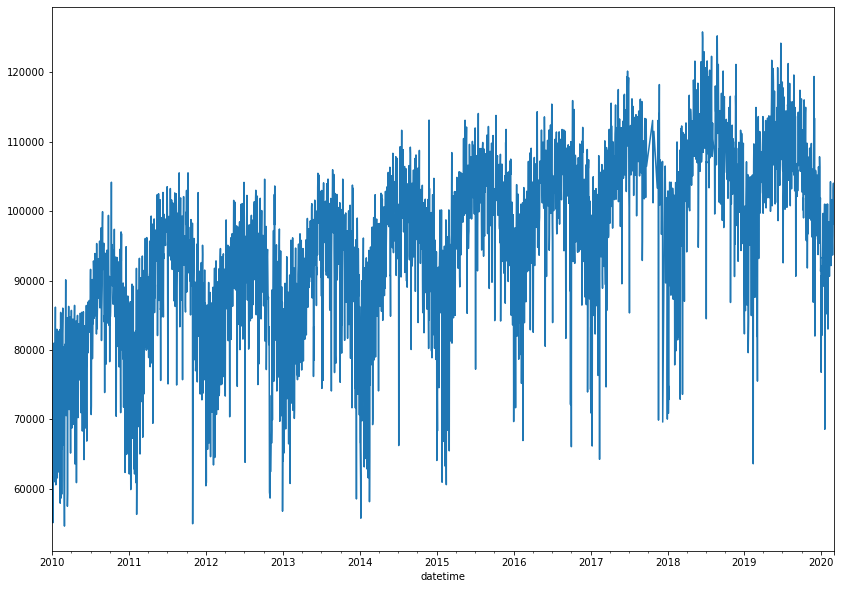

In [92]:
_a[('Throgs Neck', 'ezpass')].interpolate(limit_direction='both',method='time').plot(figsize=(14,10))

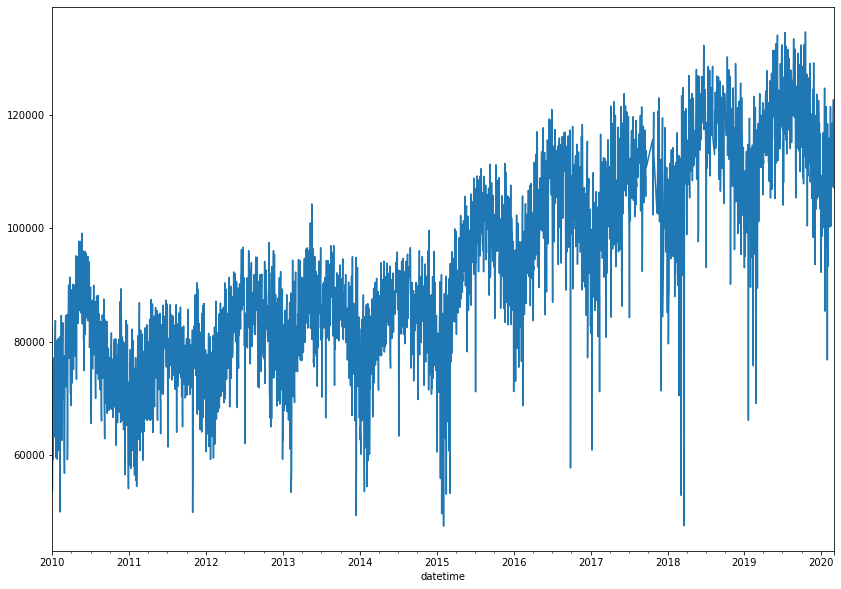

In [93]:
_a[('Whitestone', 'ezpass')].interpolate(limit_direction='both',method='time').plot(figsize=(14,10))

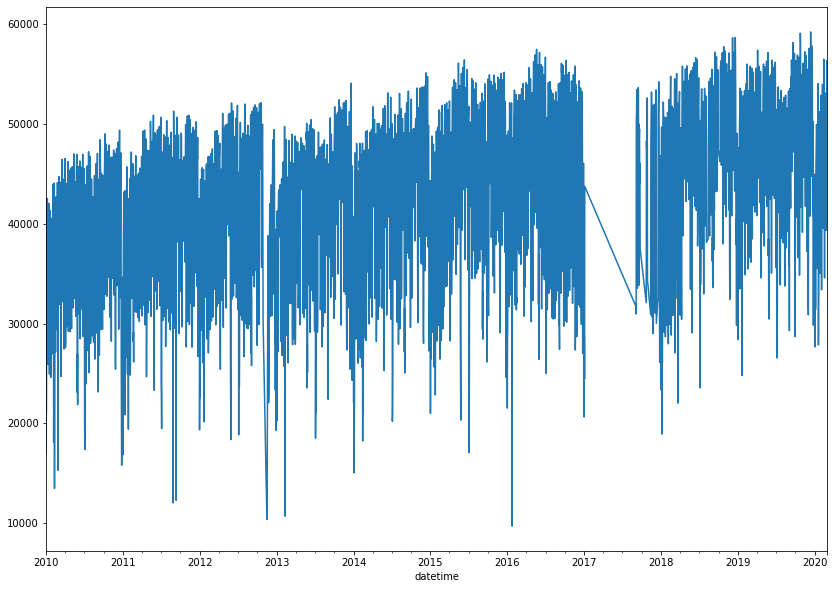

In [97]:
_a[('Brooklyn Battery', 'ezpass')].interpolate(limit_direction='both',method='time').plot(figsize=(14,10))

In [96]:
_a.isna().sum()

plaza_id          variable
Brooklyn Battery  cash        363
                  ezpass      338
Cross Bay         cash        368
                  ezpass      213
Henry Hudson      cash        379
                  ezpass      368
Marine Parkway    cash        361
                  ezpass      227
Queens Midtown    cash        355
                  ezpass      324
Throgs Neck       cash        196
                  ezpass      117
Triboro           cash        259
                  ezpass      172
Verrazano         cash        251
                  ezpass      154
Whitestone        cash        193
                  ezpass      105
dtype: int64

In [107]:
_a_to_fill

,datetime,plaza_id,variable,value
0,2010-01-01,Brooklyn Battery,cash,4902.0
1,2010-01-02,Brooklyn Battery,cash,5347.0
2,2010-01-03,Brooklyn Battery,cash,4957.0
3,2010-01-04,Brooklyn Battery,cash,5759.0
4,2010-01-05,Brooklyn Battery,cash,6096.0
...,...,...,...,...
66811,2020-02-25,Whitestone,ezpass,111954.0
66812,2020-02-26,Whitestone,ezpass,114578.0
66813,2020-02-27,Whitestone,ezpass,118259.0
66814,2020-02-28,Whitestone,ezpass,122713.0


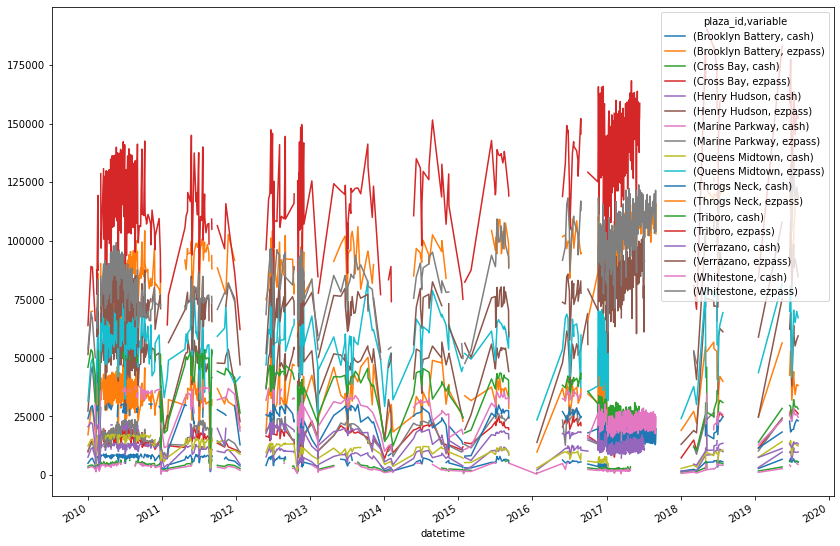

In [84]:
_a.loc[_a.isnull().any(axis=1)]

,Plaza ID,Direction,ezpass,cash,plaza_id
Date_Hour,,,,,
2020-10-24 00:00:00,21,I,1838,578,Triboro
2020-10-24 01:00:00,21,I,1084,372,Triboro
2020-10-24 02:00:00,21,I,805,260,Triboro
2020-10-24 03:00:00,21,I,766,211,Triboro
2020-10-24 04:00:00,21,I,1049,268,Triboro
...,...,...,...,...,...
2010-01-01 19:00:00,11,I,2675,1152,Verrazano
2010-01-01 20:00:00,11,I,2580,1086,Verrazano
2010-01-01 21:00:00,11,I,2302,987,Verrazano


In [16]:
df.set_index('Date_Hour', inplace=True)

In [22]:
a = df.groupby('plaza_id').resample('1D')['ezpass','cash'].sum().unstack().T

In [26]:
a

plaza_id           Brooklyn Battery  Cross Bay  Henry Hudson  Marine Parkway  \
       Date_Hour                                                               
ezpass 2010-01-01             17043       9760         27175           10243   
       2010-01-02             20799      11673         37110           11552   
       2010-01-03             21605       9983         34720           10155   
       2010-01-04             35557      16032         45846           16503   
       2010-01-05             38810      16821         49009           17418   
...                             ...        ...           ...             ...   
cash   2020-10-20              7152       3866          7237            2361   
       2020-10-21              7404       3139          7917            2474   
       2020-10-22              7376       3339          8183            2481   
       2020-10-23              7789       3450          8949            2565   
       2020-10-24              6357       3050          9958            2330   

plaza_id           Queens Midtown  Throgs Neck  Triboro  Verrazano  Whitestone  
       Date_Hour                                                                
ezpass 2010-01-01           31460        51619    63727      51385       53775  
       2010-01-02           40597        61753    76777      57562       62923  
       2010-01-03           40411        55134    75822      52374       59216  
       2010-01-04           55307        73475   107674      70059       73715  
       2010-01-05           59430        76365   111220      73630       75834  
...                           ...          ...      ...        ...         ...  
cash   2020-10-20           11367        14913    26071      10844       19530  
       2020-10-21           11356        14813    26044      10784       20808  
       2020-10-22           12444        15411    27948      11413       21779  
       2020-10-23           13362        17641    30120      12998       24210  
       2020-10-24           12198        19332    29728      13621       25112  

[7900 rows x 9 columns]